In [6]:
# Bibliotecas
import pandas as pd
import numpy as np
import glob

In [ ]:
# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv')
# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:  # lista/iterável com os caminhos tipo 'processos_1.csv', 'processos_2.csv', ...
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)


=== Arquivo carregado com sucesso! ===
Dimensões (linhas, colunas): (3245632, 10)


In [ ]:
# Carregando os dados
# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv') # mudar pasta para data pra rodar o script

# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:
    # Extrair o ano do nome do arquivo
    ano = int(arquivo.split('_')[-1].split('.')[0])
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    df_ano['ano_arquivo'] = ano  # Adicionar coluna com o ano do arquivo
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(3245632, 11)


In [3]:
# Limpeza e tratamento
# Verificar o nome correto das colunas (pode haver diferenças de acentuação ou espaços)
colunas = df.columns.tolist()

# Encontrar as colunas de data corretamente
coluna_serventia = [col for col in colunas if 'serventia' in col.lower()][0]
coluna_distribuicao = [col for col in colunas if 'data_distribuicao' in col.lower()][0]
coluna_baixa = [col for col in colunas if 'data_baixa' in col.lower()][0]
coluna_area_acao = [col for col in colunas if 'nome_area_acao' in col.lower()][0]
coluna_processo_id = [col for col in colunas if 'numero' in col.lower()][0]
coluna_comarca = [col for col in colunas if 'comarca' in col.lower()][0]

# Renomear colunas para garantir consistência
df = df.rename(columns={
coluna_distribuicao: 'data_distribuicao',
coluna_baixa: 'data_baixa',
coluna_area_acao: 'nome_area_acao',
coluna_processo_id: 'numero',
coluna_comarca: 'comarca',
coluna_serventia: 'serventia'
})

# Converter colunas de data para datetime com tratamento de erros
df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')

C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_13776\2117156001.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_13776\2117156001.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')


In [4]:
# CRIAÇÃO DAS ESTATÍSTICAS MENSAIS:

# 1. Extrair ano de distribuição e baixa
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['ano_baixa'] = df['data_baixa'].dt.year
df['mes_distribuicao'] = df['data_distribuicao'].dt.month
df['mes_baixa'] = df['data_baixa'].dt.month

# Chave de agrupamento para as estatísticas
grouping_keys = ['comarca', 'serventia', 'nome_area_acao']

# 2. Calcular Distribuídos por ano
distribuidos_df = df.dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos')
distribuidos_df = distribuidos_df.rename(columns={'ano_distribuicao': 'ano'})

# 2.1 Calcular Distribuídos por mês
distribuidos_mes_df = df.dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos_mes')
distribuidos_mes_df = distribuidos_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# 3. Calcular Baixados por ano
baixados_df = df.dropna(subset=['ano_baixa']).groupby(
    ['ano_baixa'] + grouping_keys
).size().reset_index(name='Baixados')
baixados_df = baixados_df.rename(columns={'ano_baixa': 'ano'})

# 3.1 Calcular Baixados por mês
baixados_mes_df = df.dropna(subset=['ano_baixa', 'mes_baixa']).groupby(
    ['ano_baixa', 'mes_baixa'] + grouping_keys
).size().reset_index(name='Baixados_mes')
baixados_mes_df = baixados_mes_df.rename(columns={'ano_baixa': 'ano', 'mes_baixa': 'mes'})

# 4. Calcular Pendentes por ano de distribuição
pendentes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes')
pendentes_df = pendentes_df.rename(columns={'ano_distribuicao': 'ano'})

# 4.1 Calcular Pendentes por mês de distribuição
pendentes_mes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes_mes')
pendentes_mes_df = pendentes_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# 5. Juntar tudo em uma única tabela (estatisticas)
estatisticas = pd.merge(distribuidos_df, baixados_df, on=['ano'] + grouping_keys, how='outer')
estatisticas = pd.merge(estatisticas, pendentes_df, on=['ano'] + grouping_keys, how='outer')

# 5.1 Juntar tudo em uma única tabela (estatisticas_mes)
merge_keys = ['ano', 'mes'] + grouping_keys
estatisticas_mes = pd.merge(distribuidos_mes_df, baixados_mes_df, on=merge_keys, how='outer')
estatisticas_mes = pd.merge(estatisticas_mes, pendentes_mes_df, on=merge_keys, how='outer')

# 6. Limpar e organizar o DataFrame final
estatisticas = estatisticas.fillna(0)
estatisticas[['Distribuídos', 'Baixados', 'Pendentes']] = estatisticas[['Distribuídos', 'Baixados', 'Pendentes']].astype(int)

# 6.1 Limpar e organizar o DataFrame final
estatisticas_mes = estatisticas_mes.fillna(0)
estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']] = estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']].astype(int)

# Remover linhas onde o ano não pôde ser determinado
estatisticas = estatisticas.dropna(subset=['ano'])
estatisticas['ano'] = estatisticas['ano'].astype(int)

# Remover linhas onde o mês não pôde ser determinado
estatisticas_mes = estatisticas_mes.dropna(subset=['ano', 'mes'])
estatisticas_mes[['ano', 'mes']] = estatisticas_mes[['ano', 'mes']].astype(int)

# 7. Calcular a Taxa de Congestionamento por ano
soma_pend_baix = estatisticas['Pendentes'] + estatisticas['Baixados']
estatisticas['Taxa de Congestionamento (%)'] = np.where(
    soma_pend_baix > 0,
    (estatisticas['Pendentes'] / soma_pend_baix) * 100,
    0
).round(2)

# 7.1 Calcular a Taxa de Congestionamento por mês
soma_pend_baix_mes = estatisticas_mes['Pendentes_mes'] + estatisticas_mes['Baixados_mes']
estatisticas_mes['Taxa de Congestionamento_mes (%)'] = np.where(
    soma_pend_baix_mes > 0,
    (estatisticas_mes['Pendentes_mes'] / soma_pend_baix_mes) * 100,
    0
).round(2)

# 8. Ordenar e reordenar colunas para melhor visualização
estatisticas = estatisticas.sort_values(by=['ano', 'comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True])

colunas_finais = [
    'ano', 'nome_area_acao', 'comarca', 'serventia', 
    'Distribuídos', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)'
]
estatisticas = estatisticas[colunas_finais]

# 8.1 Ordenar e reordenar colunas para melhor visualização
estatisticas_mes = estatisticas_mes.sort_values(by=['ano', 'mes','comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True, True])

colunas_finais_mes = [
    'ano', 'mes', 'nome_area_acao', 'comarca', 'serventia', 
    'Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes', 'Taxa de Congestionamento_mes (%)'
]
estatisticas_mes = estatisticas_mes[colunas_finais_mes]

#print(estatisticas.head(10))


print(estatisticas_mes.head(10))


         ano  mes                    nome_area_acao    comarca  \
144304  2025    1            Juizado Especial Cível  ABADIÂNIA   
144305  2025    1  Juizado Especial Fazenda Pública  ABADIÂNIA   
144306  2025    1                          Criminal  ABADIÂNIA   
144307  2025    1                             Cível  ABADIÂNIA   
144308  2025    1  Infância e Juventude Infracional  ABADIÂNIA   
144309  2025    1             Fazenda Pública Mista  ABADIÂNIA   
144310  2025    1                Família - Interior  ABADIÂNIA   
144311  2025    1         Juizado Especial Criminal    ACREÚNA   
144312  2025    1            Juizado Especial Cível    ACREÚNA   
144313  2025    1  Juizado Especial Fazenda Pública    ACREÚNA   

                                                serventia  Distribuídos_mes  \
144304                 Abadiânia - Juizado Especial Cível                 0   
144305          Abadiânia - Juizado das Fazendas Públicas                 0   
144306                          Abad

In [5]:
# --- CRIAÇÃO DOS TABELÕES DE ESTATÍSTICAS (ANUAL, MENSAL, SEMANAL, DIÁRIA) --- Remoção da Área de Ação
# 1. Extrair componentes de data
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['mes_distribuicao'] = df['data_distribuicao'].dt.month
df['dia_distribuicao'] = df['data_distribuicao'].dt.day
df['ano_semana_dist'] = df['data_distribuicao'].dt.isocalendar().year
df['semana_dist'] = df['data_distribuicao'].dt.isocalendar().week

df['ano_baixa'] = df['data_baixa'].dt.year
df['mes_baixa'] = df['data_baixa'].dt.month
df['dia_baixa'] = df['data_baixa'].dt.day
df['ano_semana_baixa'] = df['data_baixa'].dt.isocalendar().year
df['semana_baixa'] = df['data_baixa'].dt.isocalendar().week

# Chave de agrupamento para as estatísticas (SEM ÁREA DE AÇÃO)
grouping_keys = ['comarca', 'serventia']

# --- 2. CÁLCULOS ANUAIS ---
print("Calculando estatísticas anuais...")
# 2.1 Distribuídos por ANO
distribuidos_df = df.dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos')
distribuidos_df = distribuidos_df.rename(columns={'ano_distribuicao': 'ano'})

# 2.2 Baixados por ANO
baixados_df = df.dropna(subset=['ano_baixa']).groupby(
    ['ano_baixa'] + grouping_keys
).size().reset_index(name='Baixados')
baixados_df = baixados_df.rename(columns={'ano_baixa': 'ano'})

# 2.3 Pendentes por ANO
pendentes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes')
pendentes_df = pendentes_df.rename(columns={'ano_distribuicao': 'ano'})

# --- 3. CÁLCULOS MENSAIS ---
print("Calculando estatísticas mensais...")
# 3.1 Distribuídos por MÊS
distribuidos_mes_df = df.dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos_mes')
distribuidos_mes_df = distribuidos_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# 3.2 Baixados por MÊS
baixados_mes_df = df.dropna(subset=['ano_baixa', 'mes_baixa']).groupby(
    ['ano_baixa', 'mes_baixa'] + grouping_keys
).size().reset_index(name='Baixados_mes')
baixados_mes_df = baixados_mes_df.rename(columns={'ano_baixa': 'ano', 'mes_baixa': 'mes'})

# 3.3 Pendentes por MÊS
pendentes_mes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes_mes')
pendentes_mes_df = pendentes_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# --- 4. CÁLCULOS SEMANAIS (ISO) ---
print("Calculando estatísticas semanais...")
# 4.1 Distribuídos por SEMANA
distribuidos_semana_df = df.dropna(subset=['ano_semana_dist', 'semana_dist']).groupby(
    ['ano_semana_dist', 'semana_dist'] + grouping_keys
).size().reset_index(name='Distribuídos_semana')
distribuidos_semana_df = distribuidos_semana_df.rename(columns={'ano_semana_dist': 'ano_semana', 'semana_dist': 'semana'})

# 4.2 Baixados por SEMANA
baixados_semana_df = df.dropna(subset=['ano_semana_baixa', 'semana_baixa']).groupby(
    ['ano_semana_baixa', 'semana_baixa'] + grouping_keys
).size().reset_index(name='Baixados_semana')
baixados_semana_df = baixados_semana_df.rename(columns={'ano_semana_baixa': 'ano_semana', 'semana_baixa': 'semana'})

# 4.3 Pendentes por SEMANA
pendentes_semana_df = df[df['data_baixa'].isna()].dropna(subset=['ano_semana_dist', 'semana_dist']).groupby(
    ['ano_semana_dist', 'semana_dist'] + grouping_keys
).size().reset_index(name='Pendentes_semana')
pendentes_semana_df = pendentes_semana_df.rename(columns={'ano_semana_dist': 'ano_semana', 'semana_dist': 'semana'})

# --- 5. CÁLCULOS DIÁRIOS ---
print("Calculando estatísticas diárias...")
# 5.1 Distribuídos por DIA
distribuidos_dia_df = df.dropna(subset=['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos_dia')
distribuidos_dia_df = distribuidos_dia_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes', 'dia_distribuicao': 'dia'})

# 5.2 Baixados por DIA
baixados_dia_df = df.dropna(subset=['ano_baixa', 'mes_baixa', 'dia_baixa']).groupby(
    ['ano_baixa', 'mes_baixa', 'dia_baixa'] + grouping_keys
).size().reset_index(name='Baixados_dia')
baixados_dia_df = baixados_dia_df.rename(columns={'ano_baixa': 'ano', 'mes_baixa': 'mes', 'dia_baixa': 'dia'})

# 5.3 Pendentes por DIA
pendentes_dia_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes_dia')
pendentes_dia_df = pendentes_dia_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes', 'dia_distribuicao': 'dia'})


# --- 6. JUNÇÃO E LIMPEZA (ANUAL) ---
estatisticas_anuais = pd.merge(distribuidos_df, baixados_df, on=['ano'] + grouping_keys, how='outer')
estatisticas_anuais = pd.merge(estatisticas_anuais, pendentes_df, on=['ano'] + grouping_keys, how='outer')
estatisticas_anuais = estatisticas_anuais.fillna(0)
estatisticas_anuais[['Distribuídos', 'Baixados', 'Pendentes']] = estatisticas_anuais[['Distribuídos', 'Baixados', 'Pendentes']].astype(int)
estatisticas_anuais = estatisticas_anuais.dropna(subset=['ano'])
estatisticas_anuais['ano'] = estatisticas_anuais['ano'].astype(int)

# --- 7. JUNÇÃO E LIMPEZA (MENSAL) ---
merge_keys_mes = ['ano', 'mes'] + grouping_keys
estatisticas_mes = pd.merge(distribuidos_mes_df, baixados_mes_df, on=merge_keys_mes, how='outer')
estatisticas_mes = pd.merge(estatisticas_mes, pendentes_mes_df, on=merge_keys_mes, how='outer')
estatisticas_mes = estatisticas_mes.fillna(0)
estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']] = estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']].astype(int)
estatisticas_mes = estatisticas_mes.dropna(subset=['ano', 'mes'])
estatisticas_mes[['ano', 'mes']] = estatisticas_mes[['ano', 'mes']].astype(int)

# --- 8. JUNÇÃO E LIMPEZA (SEMANAL) ---
merge_keys_semana = ['ano_semana', 'semana'] + grouping_keys
estatisticas_semana = pd.merge(distribuidos_semana_df, baixados_semana_df, on=merge_keys_semana, how='outer')
estatisticas_semana = pd.merge(estatisticas_semana, pendentes_semana_df, on=merge_keys_semana, how='outer')
estatisticas_semana = estatisticas_semana.fillna(0)
estatisticas_semana[['Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana']] = estatisticas_semana[['Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana']].astype(int)
estatisticas_semana = estatisticas_semana.dropna(subset=['ano_semana', 'semana'])
estatisticas_semana[['ano_semana', 'semana']] = estatisticas_semana[['ano_semana', 'semana']].astype(int)

# --- 9. JUNÇÃO E LIMPEZA (DIÁRIA) ---
merge_keys_dia = ['ano', 'mes', 'dia'] + grouping_keys
estatisticas_dia = pd.merge(distribuidos_dia_df, baixados_dia_df, on=merge_keys_dia, how='outer')
estatisticas_dia = pd.merge(estatisticas_dia, pendentes_dia_df, on=merge_keys_dia, how='outer')
estatisticas_dia = estatisticas_dia.fillna(0)
estatisticas_dia[['Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia']] = estatisticas_dia[['Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia']].astype(int)
estatisticas_dia = estatisticas_dia.dropna(subset=['ano', 'mes', 'dia'])
estatisticas_dia[['ano', 'mes', 'dia']] = estatisticas_dia[['ano', 'mes', 'dia']].astype(int)


# --- 10. CÁLCULO DAS TAXAS DE CONGESTIONAMENTO ---

# 10.1 Taxa ANUAL
soma_anual = estatisticas_anuais['Pendentes'] + estatisticas_anuais['Baixados']
estatisticas_anuais['Taxa de Congestionamento (%)'] = np.where(
    soma_anual > 0, (estatisticas_anuais['Pendentes'] / soma_anual) * 100, 0
).round(2)

# 10.2 Taxa MENSAL
soma_mensal = estatisticas_mes['Pendentes_mes'] + estatisticas_mes['Baixados_mes']
estatisticas_mes['Taxa de Congestionamento_mes (%)'] = np.where(
    soma_mensal > 0, (estatisticas_mes['Pendentes_mes'] / soma_mensal) * 100, 0
).round(2)

# 10.3 Taxa SEMANAL
soma_semanal = estatisticas_semana['Pendentes_semana'] + estatisticas_semana['Baixados_semana']
estatisticas_semana['Taxa de Congestionamento_semana (%)'] = np.where(
    soma_semanal > 0, (estatisticas_semana['Pendentes_semana'] / soma_semanal) * 100, 0
).round(2)

# 10.4 Taxa DIÁRIA
soma_diaria = estatisticas_dia['Pendentes_dia'] + estatisticas_dia['Baixados_dia']
estatisticas_dia['Taxa de Congestionamento_dia (%)'] = np.where(
    soma_diaria > 0, (estatisticas_dia['Pendentes_dia'] / soma_diaria) * 100, 0
).round(2)


# --- 11. ORDENAÇÃO E COLUNAS FINAIS (CORRIGIDO) ---

# 11.1 ANUAL (Removido nome_area_acao do sort e das colunas)
estatisticas_anuais = estatisticas_anuais.sort_values(by=['ano', 'comarca', 'serventia'], ascending=[False, True, True])
colunas_finais_anuais = [
    'ano', 'comarca', 'serventia',
    'Distribuídos', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)'
]
estatisticas_anuais = estatisticas_anuais[colunas_finais_anuais]

# 11.2 MENSAL (Removido nome_area_acao do sort e das colunas)
estatisticas_mes = estatisticas_mes.sort_values(by=['ano', 'mes', 'comarca', 'serventia'], ascending=[False, True, True, True])
colunas_finais_mes = [
    'ano', 'mes', 'comarca', 'serventia',
    'Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes', 'Taxa de Congestionamento_mes (%)'
]
estatisticas_mes = estatisticas_mes[colunas_finais_mes]

# 11.3 SEMANAL (Removido nome_area_acao do sort e das colunas)
estatisticas_semana = estatisticas_semana.sort_values(by=['ano_semana', 'semana', 'comarca', 'serventia'], ascending=[False, True, True, True])
colunas_finais_semana = [
    'ano_semana', 'semana', 'comarca', 'serventia',
    'Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana', 'Taxa de Congestionamento_semana (%)'
]
estatisticas_semana = estatisticas_semana[colunas_finais_semana]

# 11.4 DIÁRIA (Removido nome_area_acao do sort e das colunas)
estatisticas_dia = estatisticas_dia.sort_values(by=['ano', 'mes', 'dia', 'comarca', 'serventia'], ascending=[False, True, True, True, True])
colunas_finais_dia = [
    'ano', 'mes', 'dia', 'comarca', 'serventia',
    'Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia', 'Taxa de Congestionamento_dia (%)'
]
estatisticas_dia = estatisticas_dia[colunas_finais_dia]


Calculando estatísticas anuais...
Calculando estatísticas mensais...
Calculando estatísticas semanais...
Calculando estatísticas diárias...


In [ ]:
# --- CRIAÇÃO DOS TABELÕES DE ESTATÍSTICAS (ANUAL, MENSAL, SEMANAL, DIÁRIA) --- 
# 1. Extrair componentes de data
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['mes_distribuicao'] = df['data_distribuicao'].dt.month
df['dia_distribuicao'] = df['data_distribuicao'].dt.day
df['ano_semana_dist'] = df['data_distribuicao'].dt.isocalendar().year
df['semana_dist'] = df['data_distribuicao'].dt.isocalendar().week

df['ano_baixa'] = df['data_baixa'].dt.year
df['mes_baixa'] = df['data_baixa'].dt.month
df['dia_baixa'] = df['data_baixa'].dt.day
df['ano_semana_baixa'] = df['data_baixa'].dt.isocalendar().year
df['semana_baixa'] = df['data_baixa'].dt.isocalendar().week

# Chave de agrupamento para as estatísticas
grouping_keys = ['comarca', 'serventia', 'nome_area_acao']

# --- 2. CÁLCULOS ANUAIS ---
print("Calculando estatísticas anuais...")
# 2.1 Distribuídos por ANO
distribuidos_df = df.dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos')
distribuidos_df = distribuidos_df.rename(columns={'ano_distribuicao': 'ano'})

# 2.2 Baixados por ANO
baixados_df = df.dropna(subset=['ano_baixa']).groupby(
    ['ano_baixa'] + grouping_keys
).size().reset_index(name='Baixados')
baixados_df = baixados_df.rename(columns={'ano_baixa': 'ano'})

# 2.3 Pendentes por ANO
pendentes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao']).groupby(
    ['ano_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes')
pendentes_df = pendentes_df.rename(columns={'ano_distribuicao': 'ano'})

# --- 3. CÁLCULOS MENSAIS ---
print("Calculando estatísticas mensais...")
# 3.1 Distribuídos por MÊS
distribuidos_mes_df = df.dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos_mes')
distribuidos_mes_df = distribuidos_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# 3.2 Baixados por MÊS
baixados_mes_df = df.dropna(subset=['ano_baixa', 'mes_baixa']).groupby(
    ['ano_baixa', 'mes_baixa'] + grouping_keys
).size().reset_index(name='Baixados_mes')
baixados_mes_df = baixados_mes_df.rename(columns={'ano_baixa': 'ano', 'mes_baixa': 'mes'})

# 3.3 Pendentes por MÊS
pendentes_mes_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao', 'mes_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes_mes')
pendentes_mes_df = pendentes_mes_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes'})

# --- 4. CÁLCULOS SEMANAIS (ISO) ---
print("Calculando estatísticas semanais...")
# 4.1 Distribuídos por SEMANA
distribuidos_semana_df = df.dropna(subset=['ano_semana_dist', 'semana_dist']).groupby(
    ['ano_semana_dist', 'semana_dist'] + grouping_keys
).size().reset_index(name='Distribuídos_semana')
distribuidos_semana_df = distribuidos_semana_df.rename(columns={'ano_semana_dist': 'ano_semana', 'semana_dist': 'semana'})

# 4.2 Baixados por SEMANA
baixados_semana_df = df.dropna(subset=['ano_semana_baixa', 'semana_baixa']).groupby(
    ['ano_semana_baixa', 'semana_baixa'] + grouping_keys
).size().reset_index(name='Baixados_semana')
baixados_semana_df = baixados_semana_df.rename(columns={'ano_semana_baixa': 'ano_semana', 'semana_baixa': 'semana'})

# 4.3 Pendentes por SEMANA
pendentes_semana_df = df[df['data_baixa'].isna()].dropna(subset=['ano_semana_dist', 'semana_dist']).groupby(
    ['ano_semana_dist', 'semana_dist'] + grouping_keys
).size().reset_index(name='Pendentes_semana')
pendentes_semana_df = pendentes_semana_df.rename(columns={'ano_semana_dist': 'ano_semana', 'semana_dist': 'semana'})

# --- 5. CÁLCULOS DIÁRIOS ---
print("Calculando estatísticas diárias...")
# 5.1 Distribuídos por DIA
distribuidos_dia_df = df.dropna(subset=['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao'] + grouping_keys
).size().reset_index(name='Distribuídos_dia')
distribuidos_dia_df = distribuidos_dia_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes', 'dia_distribuicao': 'dia'})

# 5.2 Baixados por DIA
baixados_dia_df = df.dropna(subset=['ano_baixa', 'mes_baixa', 'dia_baixa']).groupby(
    ['ano_baixa', 'mes_baixa', 'dia_baixa'] + grouping_keys
).size().reset_index(name='Baixados_dia')
baixados_dia_df = baixados_dia_df.rename(columns={'ano_baixa': 'ano', 'mes_baixa': 'mes', 'dia_baixa': 'dia'})

# 5.3 Pendentes por DIA
pendentes_dia_df = df[df['data_baixa'].isna()].dropna(subset=['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao']).groupby(
    ['ano_distribuicao', 'mes_distribuicao', 'dia_distribuicao'] + grouping_keys
).size().reset_index(name='Pendentes_dia')
pendentes_dia_df = pendentes_dia_df.rename(columns={'ano_distribuicao': 'ano', 'mes_distribuicao': 'mes', 'dia_distribuicao': 'dia'})


# --- 6. JUNÇÃO E LIMPEZA (ANUAL) ---
estatisticas_anuais = pd.merge(distribuidos_df, baixados_df, on=['ano'] + grouping_keys, how='outer')
estatisticas_anuais = pd.merge(estatisticas_anuais, pendentes_df, on=['ano'] + grouping_keys, how='outer')
estatisticas_anuais = estatisticas_anuais.fillna(0)
estatisticas_anuais[['Distribuídos', 'Baixados', 'Pendentes']] = estatisticas_anuais[['Distribuídos', 'Baixados', 'Pendentes']].astype(int)
estatisticas_anuais = estatisticas_anuais.dropna(subset=['ano'])
estatisticas_anuais['ano'] = estatisticas_anuais['ano'].astype(int)

# --- 7. JUNÇÃO E LIMPEZA (MENSAL) ---
merge_keys_mes = ['ano', 'mes'] + grouping_keys
estatisticas_mes = pd.merge(distribuidos_mes_df, baixados_mes_df, on=merge_keys_mes, how='outer')
estatisticas_mes = pd.merge(estatisticas_mes, pendentes_mes_df, on=merge_keys_mes, how='outer')
estatisticas_mes = estatisticas_mes.fillna(0)
estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']] = estatisticas_mes[['Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes']].astype(int)
estatisticas_mes = estatisticas_mes.dropna(subset=['ano', 'mes'])
estatisticas_mes[['ano', 'mes']] = estatisticas_mes[['ano', 'mes']].astype(int)

# --- 8. JUNÇÃO E LIMPEZA (SEMANAL) ---
merge_keys_semana = ['ano_semana', 'semana'] + grouping_keys
estatisticas_semana = pd.merge(distribuidos_semana_df, baixados_semana_df, on=merge_keys_semana, how='outer')
estatisticas_semana = pd.merge(estatisticas_semana, pendentes_semana_df, on=merge_keys_semana, how='outer')
estatisticas_semana = estatisticas_semana.fillna(0)
estatisticas_semana[['Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana']] = estatisticas_semana[['Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana']].astype(int)
estatisticas_semana = estatisticas_semana.dropna(subset=['ano_semana', 'semana'])
estatisticas_semana[['ano_semana', 'semana']] = estatisticas_semana[['ano_semana', 'semana']].astype(int)

# --- 9. JUNÇÃO E LIMPEZA (DIÁRIA) ---
merge_keys_dia = ['ano', 'mes', 'dia'] + grouping_keys
estatisticas_dia = pd.merge(distribuidos_dia_df, baixados_dia_df, on=merge_keys_dia, how='outer')
estatisticas_dia = pd.merge(estatisticas_dia, pendentes_dia_df, on=merge_keys_dia, how='outer')
estatisticas_dia = estatisticas_dia.fillna(0)
estatisticas_dia[['Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia']] = estatisticas_dia[['Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia']].astype(int)
estatisticas_dia = estatisticas_dia.dropna(subset=['ano', 'mes', 'dia'])
estatisticas_dia[['ano', 'mes', 'dia']] = estatisticas_dia[['ano', 'mes', 'dia']].astype(int)


# --- 10. CÁLCULO DAS TAXAS DE CONGESTIONAMENTO ---

# 10.1 Taxa ANUAL
soma_anual = estatisticas_anuais['Pendentes'] + estatisticas_anuais['Baixados']
estatisticas_anuais['Taxa de Congestionamento (%)'] = np.where(
    soma_anual > 0, (estatisticas_anuais['Pendentes'] / soma_anual) * 100, 0
).round(2)

# 10.2 Taxa MENSAL
soma_mensal = estatisticas_mes['Pendentes_mes'] + estatisticas_mes['Baixados_mes']
estatisticas_mes['Taxa de Congestionamento_mes (%)'] = np.where(
    soma_mensal > 0, (estatisticas_mes['Pendentes_mes'] / soma_mensal) * 100, 0
).round(2)

# 10.3 Taxa SEMANAL
soma_semanal = estatisticas_semana['Pendentes_semana'] + estatisticas_semana['Baixados_semana']
estatisticas_semana['Taxa de Congestionamento_semana (%)'] = np.where(
    soma_semanal > 0, (estatisticas_semana['Pendentes_semana'] / soma_semanal) * 100, 0
).round(2)

# 10.4 Taxa DIÁRIA
soma_diaria = estatisticas_dia['Pendentes_dia'] + estatisticas_dia['Baixados_dia']
estatisticas_dia['Taxa de Congestionamento_dia (%)'] = np.where(
    soma_diaria > 0, (estatisticas_dia['Pendentes_dia'] / soma_diaria) * 100, 0
).round(2)


# --- 11. ORDENAÇÃO E COLUNAS FINAIS ---

# 11.1 ANUAL
estatisticas_anuais = estatisticas_anuais.sort_values(by=['ano', 'comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True])
colunas_finais_anuais = [
    'ano', 'nome_area_acao', 'comarca', 'serventia',
    'Distribuídos', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)'
]
estatisticas_anuais = estatisticas_anuais[colunas_finais_anuais]

# 11.2 MENSAL
estatisticas_mes = estatisticas_mes.sort_values(by=['ano', 'mes', 'comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True, True])
colunas_finais_mes = [
    'ano', 'mes', 'nome_area_acao', 'comarca', 'serventia',
    'Distribuídos_mes', 'Baixados_mes', 'Pendentes_mes', 'Taxa de Congestionamento_mes (%)'
]
estatisticas_mes = estatisticas_mes[colunas_finais_mes]

# 11.3 SEMANAL
estatisticas_semana = estatisticas_semana.sort_values(by=['ano_semana', 'semana', 'comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True, True])
colunas_finais_semana = [
    'ano_semana', 'semana', 'nome_area_acao', 'comarca', 'serventia',
    'Distribuídos_semana', 'Baixados_semana', 'Pendentes_semana', 'Taxa de Congestionamento_semana (%)'
]
estatisticas_semana = estatisticas_semana[colunas_finais_semana]

# 11.4 DIÁRIA
estatisticas_dia = estatisticas_dia.sort_values(by=['ano', 'mes', 'dia', 'comarca', 'serventia', 'nome_area_acao'], ascending=[False, True, True, True, True, True])
colunas_finais_dia = [
    'ano', 'mes', 'dia', 'nome_area_acao', 'comarca', 'serventia',
    'Distribuídos_dia', 'Baixados_dia', 'Pendentes_dia', 'Taxa de Congestionamento_dia (%)'
]
estatisticas_dia = estatisticas_dia[colunas_finais_dia]


NameError: name 'df' is not defined

In [ ]:
# GERAR CSV DE TAXA DE CONGESTIONAMENTO MENSAL ZERADA

# 1. Filtrar o DataFrame para linhas onde a taxa é zero
df_taxa_zero = estatisticas_mes[estatisticas_mes['Taxa de Congestionamento_mes (%)'] == 0]

# 2. Selecionar as colunas relevantes e remover duplicatas
df_comarcas_serventias_zero = df_taxa_zero[['comarca', 'serventia', 'ano', 'mes' ,'Taxa de Congestionamento_mes (%)']].drop_duplicates()

# 3. Ordenar os resultados
df_comarcas_serventias_zero = df_comarcas_serventias_zero.sort_values(by=['comarca', 'serventia'])

# 4. Salvar em um novo arquivo CSV
output_filename_taxa_zero_csv = 'comarcas_taxa_zero.csv'
df_comarcas_serventias_zero.to_csv(output_filename_taxa_zero_csv, index=False, encoding='utf-8-sig', sep=',')

In [21]:
# GERAR CSV DE TAXA DE CONGESTIONAMENTO MENSAL ZERADA COMARCAS E SERVENTIAS ÚNICAS

# 1. Filtrar o DataFrame para linhas onde a taxa é zero
df_taxa_zero = estatisticas_mes[estatisticas_mes['Taxa de Congestionamento_mes (%)'] == 0]

# 2. Selecionar as colunas relevantes e remover duplicatas
df_comarcas_serventias_zero = df_taxa_zero[['comarca', 'serventia','Taxa de Congestionamento_mes (%)']].drop_duplicates()

# 3. Ordenar os resultados
df_comarcas_serventias_zero = df_comarcas_serventias_zero.sort_values(by=['comarca', 'serventia'])

display(df_comarcas_serventias_zero.head(20))

# 4. Salvar em um novo arquivo CSV
output_filename_taxa_zero_csv = 'comarcas_taxa_zero.csv'
df_comarcas_serventias_zero.to_csv(output_filename_taxa_zero_csv, index=False, encoding='utf-8-sig', sep=',')

,comarca,serventia,Taxa de Congestionamento_mes (%)
54011,ABADIÂNIA,Vara Judicial,0.0
54017,ACREÚNA,"1ª Vara Judicial (Família e Sucessões, Infânci...",0.0
54023,ACREÚNA,"2ª Vara Judicial (Fazendas Públicas, Criminal,...",0.0
54032,ALEXÂNIA,Vara Judicial,0.0
55559,ALTO PARAÍSO DE GOIÁS,Vara Judicial,0.0
54047,ALVORADA DO NORTE,Vara Judicial,0.0
54053,ANICUNS,"1ª Vara Judicial (Família e Sucessões, Infânci...",0.0
54058,ANICUNS,"2ª Vara Judicial (Fazendas Públicas, Criminal,...",0.0
54060,ANICUNS,CENTRO JUDICIÁRIO DE SOLUÇÃO DE CONFLITOS E CI...,0.0
55582,ANÁPOLIS,1ª Vara Criminal,0.0


In [ ]:
# Gera o arquivo CSV com o dataframe completo por ano:
output_filename = 'taxa_congestionamento.csv'
estatisticas.to_csv(output_filename, index=False, encoding='utf-8-sig', sep=',')

In [9]:
# Gera o arquivo CSV com o dataframe completo por mês
output_filename_mes = 'taxa_cong_mensal.csv'
estatisticas_mes.to_csv(output_filename_mes, index=False, encoding='utf-8-sig', sep=',')

In [10]:
# Gera o arquivo JSON com o dataframe completo
output_filename_json = 'tx_cong.json'
estatisticas.to_json(output_filename_json, orient='records', indent=4, force_ascii=False)

In [10]:
# Gera o arquivo JSON com o dataframe completo por mês
output_filename_json_mes = 'tx_cong_mensal.json'
estatisticas_mes.to_json(output_filename_json_mes, orient='records', indent=4, force_ascii=False)

In [6]:
# --- VISUALIZAÇÃO E EXPORTAÇÃO DOS RESULTADOS ---

"""# ANUAL
print("\nTabelão Geral de Estatísticas Anuais (10 primeiras linhas):")
print(estatisticas_anuais.head(10))
estatisticas_anuais.to_csv('estatisticas_anuais.csv', index=False, encoding='utf-8-sig', sep=',')
estatisticas_anuais.to_json('estatisticas_anuais.json', orient='records', indent=4, force_ascii=False)
print("Arquivos anuais salvos com sucesso.")

# MENSAL
print("\nTabelão Geral de Estatísticas Mensais (10 primeiras linhas):")
print(estatisticas_mes.head(10))
estatisticas_mes.to_csv('estatisticas_mensais.csv', index=False, encoding='utf-8-sig', sep=',')
estatisticas_mes.to_json('estatisticas_mensais.json', orient='records', indent=4, force_ascii=False)
print("Arquivos mensais salvos com sucesso.")

# SEMANAL
print("\nTabelão Geral de Estatísticas Semanais (10 primeiras linhas):")
print(estatisticas_semana.head(10))
estatisticas_semana.to_csv('estatisticas_semanais.csv', index=False, encoding='utf-8-sig', sep=',')
estatisticas_semana.to_json('estatisticas_semanais.json', orient='records', indent=4, force_ascii=False)
print("Arquivos semanais salvos com sucesso.")
"""
# DIÁRIO
print("\nTabelão Geral de Estatísticas Diárias (10 primeiras linhas):")
print(estatisticas_dia.head(10))
estatisticas_dia.to_csv('estatisticas_diarias3.csv', index=False, encoding='utf-8-sig', sep=',')
estatisticas_dia.to_json('estatisticas_diarias3.json', orient='records', indent=4, force_ascii=False)
print("Arquivos diários salvos com sucesso.")


# --- NOVA SEÇÃO: EXPORTAÇÃO COMBINADA ---
"""print("\nGerando arquivos combinados (anuais, mensais, semanais, diários)...")

# 1. Concatenar todos os DataFrames de estatísticas
#    'ignore_index=True' é essencial para criar um novo índice
#    'sort=False' previne o warning de ordenação de colunas
estatisticas_combinadas = pd.concat(
    [estatisticas_anuais, estatisticas_mes, estatisticas_semana, estatisticas_dia],
    ignore_index=True,
    sort=False
)

# 2. Ordenar o DataFrame combinado para melhor visualização
#    Ordena primeiro pela localidade, depois pelos componentes de data
estatisticas_combinadas = estatisticas_combinadas.sort_values(
    by=['comarca', 'serventia', 'nome_area_acao', 'ano', 'mes', 'dia', 'ano_semana', 'semana'],
    na_position='first' # Agrupa por localidade primeiro
)

# 3. Visualizar e Exportar o DataFrame combinado
print("\nTabelão Geral de Estatísticas Combinadas (10 primeiras linhas):")
print(estatisticas_combinadas.head(10))

estatisticas_combinadas.to_csv('estatisticas_combinadas.csv', index=False, encoding='utf-8-sig', sep=',')
estatisticas_combinadas.to_json('estatisticas_combinadas.json', orient='records', indent=4, force_ascii=False)
print("Arquivos combinados salvos com sucesso.")"""



Tabelão Geral de Estatísticas Diárias (10 primeiras linhas):
          ano  mes  dia               comarca  \
1609114  2025    1    1  APARECIDA DE GOIÂNIA   
1609115  2025    1    1                 JATAÍ   
1609116  2025    1    1        SENADOR CANEDO   
1609117  2025    1    2              ANÁPOLIS   
1609118  2025    1    2  APARECIDA DE GOIÂNIA   
1609119  2025    1    2  APARECIDA DE GOIÂNIA   
1609120  2025    1    2          CALDAS NOVAS   
1609121  2025    1    2                 CERES   
1609122  2025    1    2            CORUMBAÍBA   
1609123  2025    1    2              GOIATUBA   

                                                 serventia  Distribuídos_dia  \
1609114  Aparecida de Goiânia - UPJ Varas Criminais: 1ª...                 0   
1609115                              Jataí - 1ª Vara Cível                 0   
1609116         Senador Canedo - UPJ Varas Cíveis: 1ª e 2ª                 0   
1609117               Anápolis - 3º Juizado Especial Cível                 0  

'print("\nGerando arquivos combinados (anuais, mensais, semanais, diários)...")\n\n# 1. Concatenar todos os DataFrames de estatísticas\n#    \'ignore_index=True\' é essencial para criar um novo índice\n#    \'sort=False\' previne o warning de ordenação de colunas\nestatisticas_combinadas = pd.concat(\n    [estatisticas_anuais, estatisticas_mes, estatisticas_semana, estatisticas_dia],\n    ignore_index=True,\n    sort=False\n)\n\n# 2. Ordenar o DataFrame combinado para melhor visualização\n#    Ordena primeiro pela localidade, depois pelos componentes de data\nestatisticas_combinadas = estatisticas_combinadas.sort_values(\n    by=[\'comarca\', \'serventia\', \'nome_area_acao\', \'ano\', \'mes\', \'dia\', \'ano_semana\', \'semana\'],\n    na_position=\'first\' # Agrupa por localidade primeiro\n)\n\n# 3. Visualizar e Exportar o DataFrame combinado\nprint("\nTabelão Geral de Estatísticas Combinadas (10 primeiras linhas):")\nprint(estatisticas_combinadas.head(10))\n\nestatisticas_combinadas

C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_14916\400953868.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_14916\400953868.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')



TABELA: TAXA DE CONGESTIONAMENTO POR COMARCA (DETALHADA)
 Ano                                        comarca  Taxa de Congestionamento (%)
2014                                      ABADIÂNIA                           1.8
2014                                        ACREÚNA                          27.2
2014                                       ALEXÂNIA                           7.8
2014                          ALTO PARAÍSO DE GOIÁS                          29.9
2014                              ALVORADA DO NORTE                          12.5
2014                                        ANICUNS                           9.2
2014                                       ANÁPOLIS                           1.4
2014                           APARECIDA DE GOIÂNIA                           6.2
2014                                      ARAGARÇAS                          63.4
2014                                          ARAÇU                           8.3
2014                                    

NameError: name 'mtick' is not defined

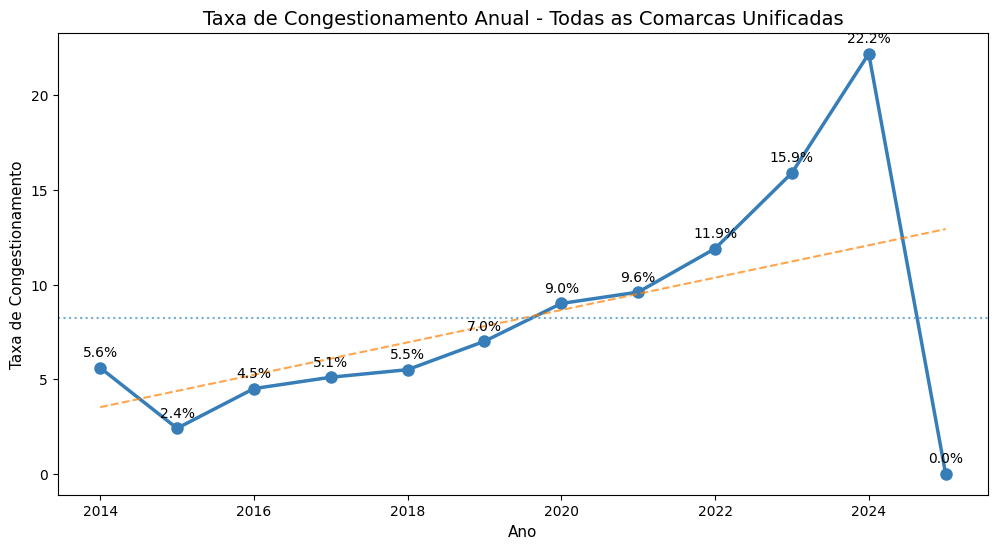

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys

# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv')
# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:  # lista/iterável com os caminhos tipo 'processos_1.csv', 'processos_2.csv', ...
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)


# Tratamento de colunas
colunas = df.columns.tolist()
def get_col(nome): return [c for c in colunas if nome in c.lower()][0]

try:
    df = df.rename(columns={
        get_col('data_distribuicao'): 'data_distribuicao',
        get_col('data_baixa'): 'data_baixa',
        get_col('nome_area_acao'): 'nome_area_acao',
        get_col('comarca'): 'comarca',
        get_col('serventia'): 'serventia'
    })
except IndexError:
    pass

df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')

# Extrair Anos
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['ano_baixa'] = df['data_baixa'].dt.year


# --- 2. CÁLCULOS ---

# 2.1 CÁLCULO DA TAXA UNIFICADA (GLOBAL) - PARA O GRÁFICO
# Agrupa apenas por ANO, somando tudo.
pendentes_total = df[df['data_baixa'].isna()].groupby('ano_distribuicao').size()
baixados_total = df.dropna(subset=['ano_baixa']).groupby('ano_baixa').size()

df_anual_unificado = pd.DataFrame({
    'Pendentes': pendentes_total,
    'Baixados': baixados_total
}).fillna(0).sort_index()

# Filtrar e Calcular
df_anual_unificado = df_anual_unificado[(df_anual_unificado['Pendentes'] > 0) | (df_anual_unificado['Baixados'] > 0)]
soma_total = df_anual_unificado['Pendentes'] + df_anual_unificado['Baixados']
df_anual_unificado['Taxa de Congestionamento (%)'] = np.where(
    soma_total > 0,
    (df_anual_unificado['Pendentes'] / soma_total) * 100,
    0
).round(1)
df_anual_unificado.index.name = 'Ano'
df_anual_unificado = df_anual_unificado.reset_index()
df_anual_unificado['Ano'] = df_anual_unificado['Ano'].astype(int)


# 2.2 CÁLCULO AGRUPADO POR COMARCA - PARA A TABELA
# Agrupa por ANO e COMARCA (ignorando serventia)
pendentes_comarca = df[df['data_baixa'].isna()].groupby(['ano_distribuicao', 'comarca']).size().reset_index(name='Pendentes')
pendentes_comarca = pendentes_comarca.rename(columns={'ano_distribuicao': 'Ano'})

baixados_comarca = df.dropna(subset=['ano_baixa']).groupby(['ano_baixa', 'comarca']).size().reset_index(name='Baixados')
baixados_comarca = baixados_comarca.rename(columns={'ano_baixa': 'Ano'})

# Juntar os dados por Ano e Comarca
df_comarca = pd.merge(pendentes_comarca, baixados_comarca, on=['Ano', 'comarca'], how='outer').fillna(0)
df_comarca[['Pendentes', 'Baixados']] = df_comarca[['Pendentes', 'Baixados']].astype(int)

# Calcular Taxa por Comarca
soma_comarca = df_comarca['Pendentes'] + df_comarca['Baixados']
df_comarca['Taxa de Congestionamento (%)'] = np.where(
    soma_comarca > 0,
    (df_comarca['Pendentes'] / soma_comarca) * 100,
    0
).round(1)

df_comarca = df_comarca.sort_values(by=['Ano', 'comarca'])
df_comarca['Ano'] = df_comarca['Ano'].astype(int)


# --- 3. EXIBIÇÃO DAS TABELAS ---

# Tabela Detalhada (Por Comarca)
print("\n" + "="*60)
print("TABELA: TAXA DE CONGESTIONAMENTO POR COMARCA (DETALHADA)")
print("="*60)
# Exibe as primeiras 20 linhas para não poluir muito, se quiser tudo remova o .head(20)
print(df_comarca[['Ano', 'comarca', 'Taxa de Congestionamento (%)']].to_string(index=False))
print("="*60 + "\n")

# Tabela Unificada (Global)
print("\n" + "="*60)
print("TABELA: TAXA DE CONGESTIONAMENTO ANUAL (UNIFICADA)")
print("="*60)
print(df_anual_unificado[['Ano', 'Taxa de Congestionamento (%)']].to_string(index=False))
print("="*60 + "\n")


# --- 4. GERAÇÃO DO GRÁFICO (UNIFICADO) ---

anos = df_anual_unificado['Ano'].values
taxas = df_anual_unificado['Taxa de Congestionamento (%)'].values

plt.figure(figsize=(12, 6))

# 4.1 Linha Principal
plt.plot(anos, taxas, marker='o', linestyle='-', linewidth=2.5, 
         color='#377eb8', label='Taxa Anual Unificada', markersize=8)

# 4.2 Rótulos
for x, y in zip(anos, taxas):
    plt.annotate(f'{y}%', 
                 (x, y), 
                 textcoords="offset points", 
                 xytext=(0, 8), 
                 ha='center', 
                 fontsize=10)

# 4.3 Linha de Tendência
if len(anos) > 1:
    z = np.polyfit(anos, taxas, 1)
    p = np.poly1d(z)
    plt.plot(anos, p(anos), linestyle='--', color='#ff7f00', alpha=0.7, linewidth=1.5, label='Tendência')

# 4.4 Média Global
media_taxa = np.mean(taxas)
plt.axhline(y=media_taxa, color='#74add1', linestyle=':', linewidth=1.5, label='Média do Período')

# Estilização
plt.title('Taxa de Congestionamento Anual - Todas as Comarcas Unificadas', fontsize=14)
plt.xlabel('Ano', fontsize=11)
plt.ylabel('Taxa de Congestionamento', fontsize=11) # Rótulo Y ajustado conforme solicitado
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.xticks(anos)
plt.grid(True, which='major', axis='both', linestyle='-', alpha=0.8)
plt.ylim(bottom=min(0, min(taxas)-1), top=max(taxas) * 1.15)
plt.legend()

# Salvar
'''plt.tight_layout()
plt.savefig('grafico_taxa_anual_unificada.png', dpi=300)
print("Gráfico gerado: grafico_taxa_anual_unificada.png")'''
plt.show() # Descomente se estiver rodando localmente com interface gráfica

C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_14916\2198421969.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
C:\Users\jcpsrodrigues\AppData\Local\Temp\ipykernel_14916\2198421969.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')


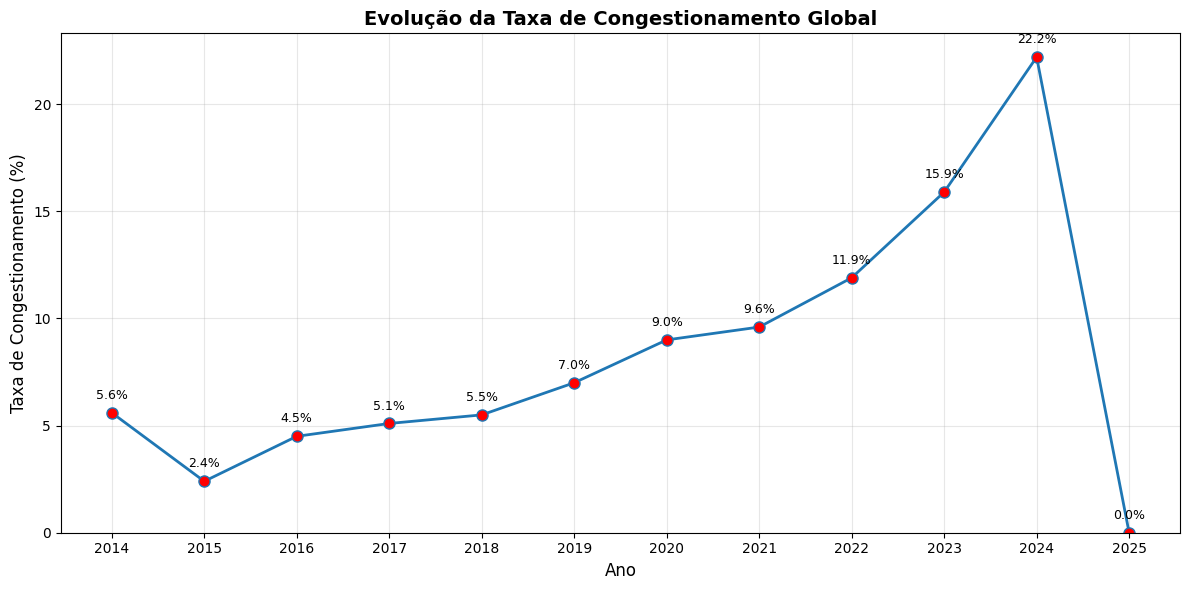


Tabela de Resultados:
Ano      Baixados     Pendentes    Taxa Cong. (%) 
------------------------------------------------------------
2014     61429        3622         5.60           
2015     140386       3487         2.40           
2016     191034       8968         4.50           
2017     299922       16242        5.10           
2018     408760       23999        5.50           
2019     470956       35192        7.00           
2020     451658       44809        9.00           
2021     613839       65203        9.60           
2022     713143       95924        11.90          
2023     822687       155146       15.90          
2024     977925       278791       22.20          
2025     698435       0            0.00           

Resumo do Processamento:
Total de arquivos CSV processados: 9
Período analisado: 2014 a 2025
Total de registros processados: 6581557


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys

# Listar os arquivos CSV na pasta 'uploads'
arquivo_csv = glob.glob('uploads/processos_*.csv')
# Carregar os arquivos CSV e concatenar em um único DataFrame
dfs = []
for arquivo in arquivo_csv:  # lista/iterável com os caminhos tipo 'processos_1.csv', 'processos_2.csv', ...
    df_ano = pd.read_csv(arquivo, sep=',', encoding='utf-8')
    dfs.append(df_ano)

df = pd.concat(dfs, ignore_index=True)

# Tratamento de colunas
colunas = df.columns.tolist()
def get_col(nome): return [c for c in colunas if nome in c.lower()][0]

df = df.rename(columns={
    get_col('data_distribuicao'): 'data_distribuicao',
    get_col('data_baixa'): 'data_baixa',
    get_col('nome_area_acao'): 'nome_area_acao',
    get_col('comarca'): 'comarca',
    get_col('serventia'): 'serventia'
})


df['data_distribuicao'] = pd.to_datetime(df['data_distribuicao'], errors='coerce')
df['data_baixa'] = pd.to_datetime(df['data_baixa'], errors='coerce')

# Extrair Anos
df['ano_distribuicao'] = df['data_distribuicao'].dt.year
df['ano_baixa'] = df['data_baixa'].dt.year

# Cálculo da taxa de congestionamento
# Agrupa apenas por ANO, somando tudo.
pendentes_total = df[df['data_baixa'].isna()].groupby('ano_distribuicao').size()
baixados_total = df.dropna(subset=['ano_baixa']).groupby('ano_baixa').size()

df_anual_unificado = pd.DataFrame({
    'Pendentes': pendentes_total,
    'Baixados': baixados_total
}).fillna(0).sort_index()

# Filtrar e Calcular
df_anual_unificado = df_anual_unificado[(df_anual_unificado['Pendentes'] > 0) | (df_anual_unificado['Baixados'] > 0)]
soma_total = df_anual_unificado['Pendentes'] + df_anual_unificado['Baixados']
df_anual_unificado['Taxa de Congestionamento (%)'] = np.where(
    soma_total > 0,
    (df_anual_unificado['Pendentes'] / soma_total) * 100,
    0
).round(1)
df_anual_unificado.index.name = 'Ano'
df_anual_unificado = df_anual_unificado.reset_index()
df_anual_unificado['Ano'] = df_anual_unificado['Ano'].astype(int)

# Criar o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_anual_unificado['Ano'], df_anual_unificado['Taxa de Congestionamento (%)'], 
         marker='o', linewidth=2, markersize=8, markerfacecolor='red')

# Adicionar anotações com os valores
for i, row in df_anual_unificado.iterrows():
    plt.annotate(f"{row['Taxa de Congestionamento (%)']:.1f}%", 
                (row['Ano'], row['Taxa de Congestionamento (%)']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9)

# Configurações do gráfico
plt.title('Evolução da Taxa de Congestionamento Global', fontsize=14, fontweight='bold')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Congestionamento (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(df_anual_unificado['Ano'])  # Garantir que todos os anos sejam mostrados como inteiros

# Ajustar limites do eixo Y para melhor visualização
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# Criar tabela com os resultados
tabela_resultados = df_anual_unificado.copy()

print("\nTabela de Resultados:")
print("=" * 60)
print(f"{'Ano':<8} {'Baixados':<12} {'Pendentes':<12} {'Taxa Cong. (%)':<15}")
print("-" * 60)
for _, row in tabela_resultados.iterrows():
    print(f"{int(row['Ano']):<8} {int(row['Baixados']):<12} {int(row['Pendentes']):<12} {row['Taxa de Congestionamento (%)']:<15.2f}")

# DataFrame formatado para uso posterior
df_tabela_final = tabela_resultados[['Ano', 'Baixados', 'Pendentes', 'Taxa de Congestionamento (%)']].copy()
df_tabela_final['Ano'] = df_tabela_final['Ano'].astype(int)
df_tabela_final['Baixados'] = df_tabela_final['Baixados'].astype(int)
df_tabela_final['Pendentes'] = df_tabela_final['Pendentes'].astype(int)

# Exibir informações sobre os dados processados
print(f"\nResumo do Processamento:")
print(f"Total de arquivos CSV processados: {len(arquivo_csv)}")
print(f"Período analisado: {df_tabela_final['Ano'].min()} a {df_tabela_final['Ano'].max()}")
print(f"Total de registros processados: {len(df)}")